In [1]:
import pandas as pd
data = pd.read_csv('dataset.csv')

In [2]:
data = data.drop(['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'popularity','Unnamed: 0'], axis=1)

# remove more features
data = data.drop(['key', 'mode', 'time_signature'], axis=1)
# tried removing other various features here, but it didn't improve the accuracy



In [3]:
# Convert 'explicit' column to integer type
#data['explicit'] = data['explicit'].astype(int)
# Check for missing values
data.isnull().sum()

duration_ms         0
explicit            0
danceability        0
energy              0
loudness            0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
track_genre         0
dtype: int64

In [4]:
# Check the distribution of genres
genre_counts = data['track_genre'].value_counts()
genre_counts


acoustic             1000
punk-rock            1000
progressive-house    1000
power-pop            1000
pop                  1000
                     ... 
folk                 1000
emo                  1000
electronic           1000
electro              1000
world-music          1000
Name: track_genre, Length: 114, dtype: int64

In [5]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Define the target variable and the features
X = data.drop('track_genre', axis=1)
y = data['track_genre']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Calculate the baseline accuracy if we randomly guess
random_guessing_accuracy = 1 / len(genre_counts)

# Initialize a dummy classifier
dummy_clf = DummyClassifier(strategy="stratified", random_state=42)

# Fit the dummy classifier
dummy_clf.fit(X_train, y_train)

# Make predictions on the test set
dummy_predictions = dummy_clf.predict(X_test)

# Calculate the baseline accuracy of the dummy classifier
dummy_accuracy = accuracy_score(y_test, dummy_predictions)

random_guessing_accuracy, dummy_accuracy


(0.008771929824561403, 0.008640350877192983)

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

# Remove non-relevant columns
#X = X.drop(['track_id', 'artists', 'album_name', 'track_name', 'Unnamed: 0'], axis=1)

# Convert boolean 'explicit' column to int
#X['explicit'] = X['explicit'].astype(int)

# Initialize the LabelEncoder
le = LabelEncoder()

# Fit and transform the target variable
y = le.fit_transform(y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the classifier
clf = DecisionTreeClassifier(random_state=42)

# Fit the classifier
clf.fit(X_train, y_train)

# Predict the test set results
y_pred = clf.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

accuracy


0.16728070175438597

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Define the reduced parameter grid
param_grid = {
    'max_depth': list(range(10, 51, 10)),
    'min_samples_split': list(range(10, 101, 20)),
}

# Initialize the GridSearchCV
#grid_search = GridSearchCV(clf, param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Fit the GridSearchCV
#grid_search.fit(X_train, y_train)


# Initialize the RandomizedSearchCV with reduced iterations
random_search = RandomizedSearchCV(clf, param_grid, n_iter=10, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)

# Fit the RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best parameters
best_params = random_search.best_params_

# Train and evaluate the classifier with the best parameters
clf = DecisionTreeClassifier(**best_params, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
tuned_accuracy = accuracy_score(y_test, y_pred)

best_params, tuned_accuracy


({'min_samples_split': 70, 'max_depth': 50}, 0.18144736842105263)

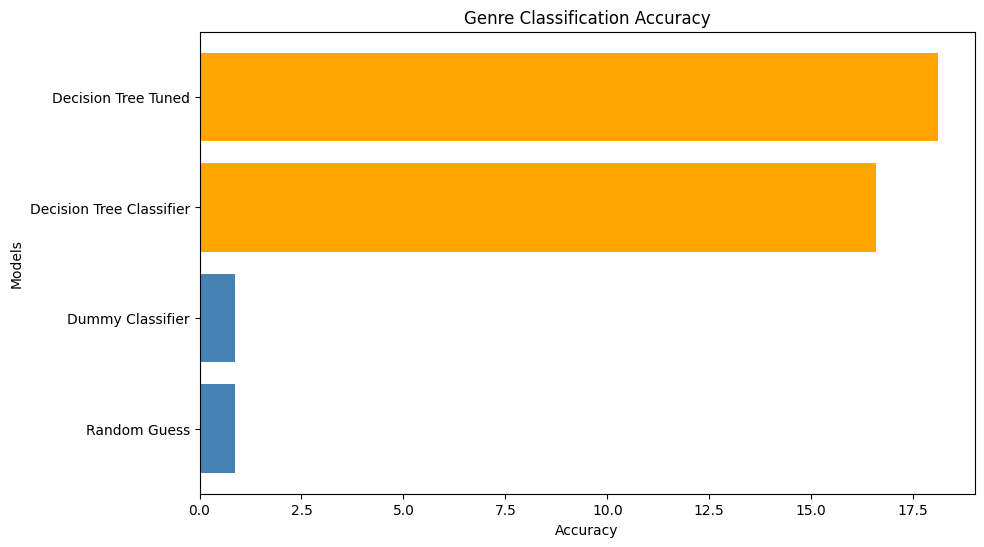

In [84]:
import matplotlib.pyplot as plt

model_names = ["Random Guess", "Dummy Classifier", "Decision Tree Classifier", "Decision Tree Tuned"]
values = [0.877, 0.864, 16.6, 18.1]

colors = ['orange' if model in ["Decision Tree Classifier", "Decision Tree Tuned"] else 'steelblue' for model in model_names]


plt.figure(figsize=(10,6))
plt.barh(model_names, values, color=colors)
plt.xlabel('Accuracy')
plt.ylabel('Models')
plt.title('Genre Classification Accuracy')
plt.show()


Baselines:  
- Random guessing: Since all genres are equally represented, the probability of correctly guessing a genre at random is simply the reciprocal of the number of unique genres.

- Dummy classifier: This classifier makes predictions using simple rules, which can be useful as a baseline comparison against actual models. The "stratified" strategy generates predictions by respecting the class distribution of the training set. This would be a good choice considering the equal distribution of genres in our dataset.

Tuning:  
Used randomSearchCV to help select groups of attributes.

In [8]:
# normalize duration
X['duration_ms'] = (X['duration_ms'] - X['duration_ms'].mean()) / X['duration_ms'].std()
# normalize loudness
X['loudness'] = (X['loudness'] - X['loudness'].mean()) / X['loudness'].std()
# normalize tempo
X['tempo'] = (X['tempo'] - X['tempo'].mean()) / X['tempo'].std()
# normalize key
#X['key'] = (X['key'] - X['key'].mean()) / X['key'].std()

In [9]:
#X = data.drop('explicit', axis=1)
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train another classifier with the best parameters
#clf = DecisionTreeClassifier(**best_params, random_state=42)
#clf.fit(X_train, y_train)
#y_pred = clf.predict(X_test)
#new_tuned_accuracy = accuracy_score(y_test, y_pred)
#tuned_accuracy - new_tuned_accuracy


In [87]:
# Train a NN classifier for X to classify genre (y)
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test set
X_test_scaled = scaler.transform(X_test)

# Initialize the MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=400, random_state=42)

# Fit the MLPClassifier
mlp.fit(X_train_scaled, y_train)

# Predict the test set labels
y_pred = mlp.predict(X_test_scaled)

# Calculate the accuracy score
mlp_accuracy = accuracy_score(y_test, y_pred)

mlp_accuracy



c:\Users\Alec\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


0.223859649122807

In [88]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the classifier
rf_clf = RandomForestClassifier(random_state=42)

# Fit the classifier
rf_clf.fit(X_train, y_train)

# Predict the test set results
y_pred_rf = rf_clf.predict(X_test)

# Calculate the accuracy of the model
rf_accuracy = accuracy_score(y_test, y_pred_rf)

rf_accuracy


0.25407894736842107

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Define the target variable and the features
#X = dataset.drop(['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'popularity', 'key', 'mode', 'time_signature', 'track_genre'], axis=1)
#y = dataset['track_genre']

# Initialize the LabelEncoder
le = LabelEncoder()

# Fit and transform the target variable
y = le.fit_transform(y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize the classifier
rf_clf = RandomForestClassifier(random_state=42)

# Fit the classifier
rf_clf.fit(X_train, y_train)

# Predict the test set results
y_pred_rf = rf_clf.predict(X_test)

# Calculate the accuracy of the model
rf_accuracy = accuracy_score(y_test, y_pred_rf)

rf_accuracy


0.25407894736842107

In [13]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
param_grid_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

# Initialize the RandomizedSearchCV
random_search_rf = RandomizedSearchCV(rf_clf, param_grid_rf, n_iter=20, cv=3, scoring='accuracy', n_jobs=-1, random_state=42, verbose=2)

# Fit the RandomizedSearchCV
random_search_rf.fit(X_train, y_train)

# Get the best parameters
best_params_rf = random_search_rf.best_params_

# Train and evaluate the classifier with the best parameters
rf_clf_best = RandomForestClassifier(**best_params_rf, random_state=42)
rf_clf_best.fit(X_train, y_train)
y_pred_rf_best = rf_clf_best.predict(X_test)
tuned_rf_accuracy = accuracy_score(y_test, y_pred_rf_best)

best_params_rf, tuned_rf_accuracy


Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\Alec\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
33 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Alec\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Alec\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\Alec\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", l

({'n_estimators': 200,
  'min_samples_split': 2,
  'min_samples_leaf': 1,
  'max_features': 'sqrt',
  'max_depth': 30},
 0.257719298245614)

In [14]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the classifier
gb_clf = GradientBoostingClassifier(random_state=42)

# Fit the classifier
gb_clf.fit(X_train, y_train)

# Predict the test set results
y_pred_gb = gb_clf.predict(X_test)

# Calculate the accuracy of the model
gb_accuracy = accuracy_score(y_test, y_pred_gb)

gb_accuracy


0.21618421052631578

In [15]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler

# Scale the features for SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the LinearSVC
svm_clf = svm.LinearSVC(random_state=42)

# Fit the classifier
svm_clf.fit(X_train_scaled, y_train)

# Predict the test set results
y_pred_svm = svm_clf.predict(X_test_scaled)

# Calculate the accuracy of the model
svm_accuracy = accuracy_score(y_test, y_pred_svm)

svm_accuracy


c:\Users\Alec\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\Alec\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.14096491228070177

achieved an accuracy of approximately 14.1%. This is lower than the accuracy we achieved with the Random Forest model (25.77%).

Given these results, I suggest we proceed with Logistic Regression. Logistic Regression is a simpler model, but it can be surprisingly effective for many tasks and is less computationally intensive than SVM or Gradient Boosting.

Let's proceed with Logistic Regression. We will use a one-vs-rest (OvR) strategy to handle the multi-class nature of the problem. The LogisticRegression class from Scikit-Learn uses OvR by default when you train it on more than two classes.

In [16]:
from sklearn.linear_model import LogisticRegression

# Initialize the classifier
log_reg_clf = LogisticRegression(random_state=42)

# Fit the classifier
log_reg_clf.fit(X_train, y_train)

# Predict the test set results
y_pred_log_reg = log_reg_clf.predict(X_test)

# Calculate the accuracy of the model
log_reg_accuracy = accuracy_score(y_test, y_pred_log_reg)

log_reg_accuracy


c:\Users\Alec\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.16030701754385965

The Logistic Regression model achieved an accuracy of approximately 16.03%, which is an improvement over the SVM model but still lower than the Random Forest model.

The warning message suggests that the Logistic Regression model did not converge and reached the maximum number of iterations. This typically means that the model could potentially improve if allowed to run for more iterations. This can be done by increasing the max_iter parameter.

However, before we adjust this parameter, I would suggest scaling the features. Scaling is a common requirement for many machine learning estimators; they might behave poorly if the individual features do not more or less resemble standard normally distributed data (Gaussian with zero mean and unit variance). The warning message provides a link to the Scikit-learn documentation that suggests scaling the data.

Let's scale the features and run the Logistic Regression model again with a higher maximum number of iterations. 

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the classifier with a higher max_iter
log_reg_clf = LogisticRegression(max_iter=1000, random_state=42)

# Fit the classifier
log_reg_clf.fit(X_train_scaled, y_train)

# Predict the test set results
y_pred_log_reg = log_reg_clf.predict(X_test_scaled)

# Calculate the accuracy of the model
log_reg_accuracy = accuracy_score(y_test, y_pred_log_reg)

log_reg_accuracy


0.16429824561403508

Ensemble methods can be a very effective way to improve the performance of your model. The main idea is to combine the predictions of several base estimators built with a given learning algorithm in order to improve generalizability and robustness.

There are several methods to create an ensemble model:

Bagging methods: Bagging methods work by constructing several instances of a black-box estimator on random subsets of the original training set and then aggregate their individual predictions to form a final prediction. An example of a bagging method is a Random Forest.

Boosting methods: Boosting methods are a set of algorithms used to convert weak learners into strong learners. The main principle of boosting is to fit a sequence of weak learners (models that are only slightly better than random guessing) to weighted versions of the data, where more weight is given to examples that were misclassified by earlier rounds. Examples of boosting methods are AdaBoost and Gradient Boosting.

Stacking (or Stacked Generalization): This involves training a learning algorithm to combine the predictions of several other learning algorithms. The idea is to train a model to learn the best way to combine the input models.

Since we've already tried Random Forest (a bagging method) and Gradient Boosting (a boosting method) and they were computationally expensive, I'd recommend trying Stacking.

In [18]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

# Define the base models
level0 = list()
level0.append(('lr', LogisticRegression(max_iter=1000)))
level0.append(('rf', RandomForestClassifier(n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=30)))
level0.append(('svm', svm.LinearSVC()))

# Define meta learner model
level1 = LogisticRegression()

# Define the stacking ensemble
stacking_model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)

# Fit the model on our data
stacking_model.fit(X_train_scaled, y_train)

# Predict the test set results
y_pred_stacking = stacking_model.predict(X_test_scaled)

# Calculate the accuracy of the model
stacking_accuracy = accuracy_score(y_test, y_pred_stacking)

stacking_accuracy


c:\Users\Alec\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
